Section 1: import necessary python libraries

In [1]:
### matplotlib backend configuration 1; works but not behave nicely
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

### matplotlib backend configuration 2; does not work in my system
#%matplotlib notebook

### matplotlib backend configuration 3; does not work in my system
#import matplotlib
#matplotlib.use('nbagg')

### matplotlib backend configuration 4; work well as configuration 5
#%matplotlib widget

### matplotlib backend configuration 5
#%matplotlib ipympl

### matplotlib backend configuration 6
#%matplotlib osx

#%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]

from importlib import reload
from pathlib import Path
import h5py
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
import numpy as np
import xanes_spectra_filters as xsf
xsf = reload(xsf)
import xanes_analysis as xa
xa = reload(xa)
import xanes_math as xm
xm = reload(xm)
import os

try:
    import imagej
    ij = imagej.init('/home/xiao/software/Fiji.app', headless=False)
    ijui = ij.ui()
    ijui.showUI()
except:
    print('Fiji is launched already!')
ij.py.run_macro("""run("Brightness/Contrast...");""")

from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')

def fiji_close_all():
    imp = WindowManager.getCurrentImage()
    while imp is not None:
        imp.close()
        imp = WindowManager.getCurrentImage()
fiji_close_all()        
print('\033[04m\033[01m\033[34m     Section 1 finished     ')  

Added 387 JARs to the Java classpath.
     Section 1 finished     


Section 2: User inputs

In [11]:
# file path
#fn_template = '/media/Disk2/data/AIJUN_LI_Proposal_304474_June28_2019/aligned_multipos_2D_xanes_scan2_id_{0}_repeat_00_pos_00.h5'
#fn_template = '/media/Disk2/data/Yuan_June2019/aligned_xanes_scan2_id_{0}.h5'
fn_template = '/NSLS2/xf18id1/users/2020Q1/MATEUSZ_Proposal_305729/aligned_xanes_scan2_id_{}.h5'
# scan number
scan_id = 53210
#21214, 21221
# define 'bad' image id below. These are the image indices that are not well aligned with other images.
# Notice that these indices are the index number in ImageJ minus 1. Alternatively, you can use HDFView
# to check image alignment. In this case, the indices here are same as the indices in HDFView. If there
# is no bad images, leave it as 'bad_img_ids = []'
bad_img_ids = []
# edge_offset from Co
edge_offset_2_Co = 6.539 - 8.333
# estimated edge energy
edge_eng = 8.333 + edge_offset_2_Co
# end poit of the pre-edge relative to the edge_eng in keV
pre_ee = -0.05
# start point of the post-edge relative to the edge_eng in keV
post_es = 0.1
# how many times of the edge jump magnitude should be compared to the pre-edge standard deviation
edge_jump_threshold = 1
# how much should the pre_edge be offset up for validating if the post edge trend is in a reasonable range
# this is a factor to the pre-edge deviation
pre_edge_threshold = 1.5
# define an energy range for 0.5 absorption postion fitting
ep_eng_s = 8.335 + edge_offset_2_Co
ep_eng_e = 8.350 + edge_offset_2_Co
# define an energy range for whiteline peak postion fitting
wl_eng_s = 8.337 + edge_offset_2_Co + 0.000
wl_eng_e = 8.357 + edge_offset_2_Co - 0.000

# define an energy range for edge_pos display
ep_vmin = 8.338 + edge_offset_2_Co
ep_vmax = 8.348 + edge_offset_2_Co
# define an energy range for whiteline display
wl_vmin = 8.342 + edge_offset_2_Co
wl_vmax = 8.352 + edge_offset_2_Co
# define path and file name to save xanes analysis results; if you use the default path and name as below,
# you don't need to change anything. otherwise, give your full path and file name below.
out_fn = os.path.join(str(Path(fn_template).parent), 'xanes_analysis_' + str(Path(fn_template).name)).format(scan_id)
print(out_fn)
print('\033[04m\033[01m\033[34m     Section 2 finished     ')   

/NSLS2/xf18id1/users/2020Q1/MATEUSZ_Proposal_305729/xanes_analysis_aligned_xanes_scan2_id_53210.h5
     Section 2 finished     


In [12]:
fn = Path(fn_template.format(scan_id))
f = h5py.File(fn, 'r')
spec = f['/registration/registered_image'][:]
eng = f['/raw_data_info/X_eng'][:]
mask = f['/raw_data_info/mask'][:].reshape([-1, spec.shape[1], spec.shape[2]])
f.close()
print('raw data spectrum shape is:', spec.shape,
      ', and energy shape is:', eng.shape)
xana = xa.xanes_analysis(spec, eng, edge_eng, pre_ee=pre_ee, post_es=post_es, 
                         edge_jump_threshold=edge_jump_threshold, 
                         pre_edge_threshold=pre_edge_threshold)
print('pre-edge index range is:', [xana.pre_es_idx, xana.pre_ee_idx],
      ', and post-edge index range is:', [xana.post_es_idx, xana.post_ee_idx])
xana.remove_slice_img(bad_img_ids)
xana.edge_jump()
xana.cal_pre_edge_sd()

xana.cal_post_edge_sd()
xana.fit_pre_edge()
xana.fit_post_edge()
# functions work but still need to improve member variable archietecture design
xana.create_edge_jump_filter(edge_jump_threshold)
xana.create_fitted_edge_filter(pre_edge_threshold)
xana.normalize_xanes(edge_eng, order=0)
xana.fit_edge_pos(ep_eng_s, ep_eng_e)
xana.fit_whiteline(wl_eng_s, wl_eng_e, order=3)
xana.calc_direct_whiteline(wl_eng_s, wl_eng_e)
xana.save_results(out_fn)
print('\033[04m\033[01m\033[34m     Section 3 finished     ')   

raw data spectrum shape is: (101, 500, 580) , and energy shape is: (101,)
pre-edge index range is: [0, 7] , and post-edge index range is: [91, 100]
pre_edge_fit.shape (2, 500, 580)
np.polyval(pre_edge_fit, eng).shape (101, 500, 580)
fitted_edge_filter.shape: (1, 500, 580)
pre_edge_sd.shape: (500, 580)
(500, 580)
     Section 3 finished     


In [13]:
try:
    for ip in imgp:
        ip.close()
    imgp = []
except:
    imgp = []
    
xana.calc_direct_whiteline_peak_height(wl_eng_s, wl_eng_e)
ijui.show(ij.py.to_java(xana.direct_whiteline_ph))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('wl_peak_height')
imgp.append(imp1)

xana.calc_weighted_eng(7.7)
ijui.show(ij.py.to_java(xana.centroid_of_eng))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('centroid_of_eng')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.normalized_spectrum))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('normalized_spectrum')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.weighted_atten))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('weighted_atten')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.weighted_eng))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('weighted_eng')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.whiteline_pos_direct*mask))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('whiteline_pos_direct')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.whiteline_pos*mask))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('whiteline_pos')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.whiteline_pos*xana.edge_jump_mask))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('whiteline_pos*edge_jump_mask')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.whiteline_pos*xana.fitted_edge_mask))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('whiteline_pos*fitted_edge_mask')
imgp.append(imp1)

ijui.show(ij.py.to_java(xana.whiteline_pos*xana.edge_jump_mask*xana.fitted_edge_mask))
imp1 = WindowManager.getCurrentImage()
imp1.setTitle('whiteline_pos*edge_jump_mask*fitted_edge_mask')
imgp.append(imp1)

In [10]:
fiji_close_all()

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 3 ,1)
ax1.imshow(xana.edge_jump_mask)
ax1.set_title('ej_mask', fontdict={'fontsize':12})

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow((xana.spectrum*xana.edge_jump_mask*xana.fitted_edge_mask)[int(xana.spectrum.shape[0]/2)])
ax2.set_title('ej_mask&pe_mask * raw_spectrum', fontdict={'fontsize':12})

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(xana.fitted_edge_mask[0])
ax3.set_title('pe_mask', fontdict={'fontsize':12})
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'ej_mask&fe_mask * edge_eng_pos')

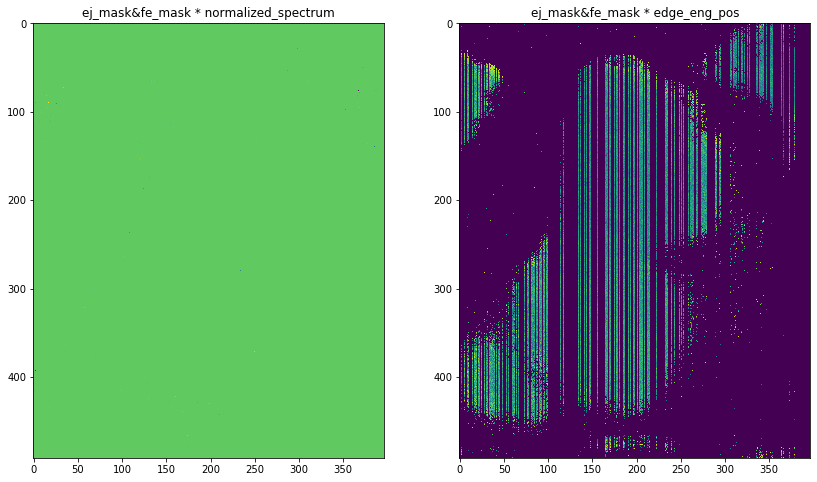

In [756]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)

_, numrows, numcols = xana.normalized_spectrum.shape


def format_coord(x, y):
    col = int(x + 0.5)
    row = int(y + 0.5)
    if col >= 0 and col < numcols and row >= 0 and row < numrows:
        z = xana.edge_eng_pos[50, row, col]
        return 'x=%1.4f, y=%1.4f, z=%1.4f' % (x, y, z)
    else:
        return 'x=%1.4f, y=%1.4f' % (x, y)


#ax1.format_coord = lambda x,y,z: '%6.6f, %6.6f, %6.6f' % (x,y,ax1.get_array()[x,y])
ax1.imshow((xana.normalized_spectrum*xana.edge_jump_mask*xana.fitted_edge_mask)[int(xana.normalized_spectrum.shape[0]/2)])
ax1.set_title('ej_mask&fe_mask * normalized_spectrum', fontdict={'fontsize':12})

ax2 = fig.add_subplot(1, 2, 2)
ax2.format_coord = format_coord
#ax2.imshow((xana.edge_eng_pos*xana.edge_jump_mask*xana.fitted_edge_mask[0]), vmin=ep_vmin, vmax=ep_vmax)
ax2.imshow((xana.edge_eng_pos*xana.edge_jump_mask*xana.fitted_edge_mask[0]), vmin=8.33, vmax=8.35)
ax2.set_title('ej_mask&fe_mask * edge_eng_pos', fontdict={'fontsize':12})


(492, 397) (101, 492, 397)
8.337 8.357
(492, 397) (101, 492, 397)


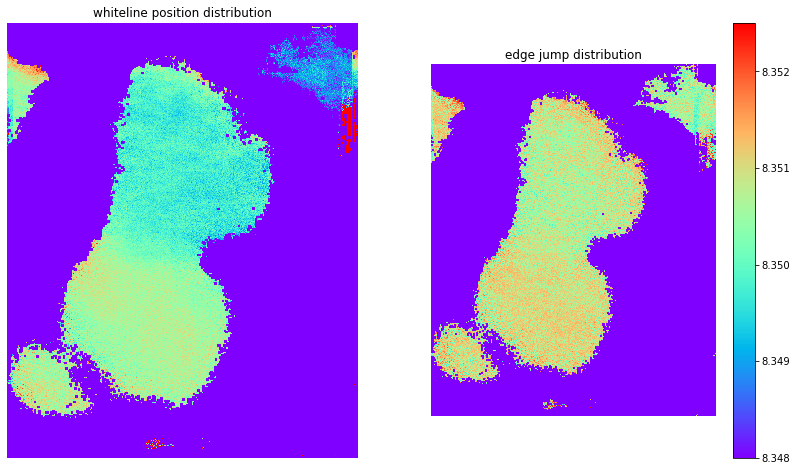

In [757]:
fig = plt.figure()
window_size = 3
thresh_niblack = threshold_niblack(xana.edge_jump_mask, window_size=window_size, k=0.1)
ax1 = fig.add_subplot(1, 2, 1)
#ax1.format_cursor_data(ax1.get_cursor_data('button_press_event'))
#ax1.format_cursor_data(ax1.get_cursor_data('motion_notify_event'))
#ax1.set_title('filtered_ej_mask * wl', fontdict={'fontsize':12})

ax1.set_title('whiteline position distribution', fontdict={'fontsize':12})
ax1.set_axis_off()
print(xana.whiteline_pos.shape, mask.shape)
p1 = ax1.imshow(np.squeeze(xana.whiteline_pos)*thresh_niblack*mask[0], vmin=wl_eng_s-0.000, vmax=wl_eng_e-0.000, cmap='rainbow')
print(wl_eng_s, wl_eng_e)
p1.set_clim(wl_eng_s+0.011, wl_eng_e-0.0045)

ax2 = fig.add_subplot(1, 2, 2)
ax2.format_cursor_data(ax2.get_cursor_data('motion_notify_event'))
ax2.set_title('edge jump distribution', fontdict={'fontsize':12})
ax2.set_axis_off()
print(xana.edge_eng_pos.shape, mask.shape)
p2 = ax2.imshow(np.squeeze(xana.edge_eng_pos)*thresh_niblack*mask[0], 
               vmin=wl_eng_s-0.009, vmax=wl_eng_e+0.000, cmap='rainbow')
p2.set_clim(ep_eng_s-0.009, ep_eng_e+0.000)

fig.colorbar(p1)
plt.show()

In [7]:
print(mask.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mask[0])
plt.show()

(101, 1000, 860)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
fig, axs = plt.subplots(1, 1)
#print(axs.shape)
axs.plot(xana.eng, xana.normalized_spectrum[:, 420:440, 550:570].mean(axis=(1,2))-\
         xana.normalized_spectrum[:, 420:440, 840:860].mean(axis=(1,2)))
#axs.plot(xana.eng, xana.normalized_spectrum[:, 420:440, 550:570].mean(axis=(1,2)))
#axs.plot(xana.eng, xana.normalized_spectrum[:, 420:440, 840:860].mean(axis=(1,2)))
axs.set_ylim(-0.1, 0.9)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
# [ystart, yend, xstart, xend]
#roi = [460, 490, 510, 540]   ## 21221
roi = [460, 1610, 670, 1950]   ## 21221
#roi = [510, 610, 670, 770]   ## 21214
#roi = [350, 450, 410, 510]   ## 21214

print(wl_eng_s, wl_eng_e)
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(xana.eng, xana.normalized_spectrum[:, 370:390, 220:240].mean(axis=(1,2)), 'r')
plt.plot(xana.eng, xana.normalized_spectrum[:, roi[0]:roi[1], roi[2]:roi[3]].mean(axis=(1,2)), 'g')
#ax.plot(xana.eng, xana.normalized_spectrum[:, 420:440, 440:460].mean(axis=(1,2)), 'b')
ax.set_autoscale_on(True)
ax.tick_params(top=True, which='both')
ax.minorticks_on()
ax.set_xlabel('X-ray energy (keV)')
ax.set_ylabel('Normalized Absorption (a. u.)')
plt.show()

8.337 8.357


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
print(xana.eng)
print(xana.eng.shape)

[8.212 8.222 8.232 8.242 8.252 8.262 8.272 8.282 8.292 8.302 8.312 8.313
 8.314 8.315 8.316 8.317 8.318 8.319 8.32  8.321 8.322 8.323 8.324 8.325
 8.326 8.327 8.328 8.329 8.33  8.331 8.332 8.333 8.334 8.335 8.336 8.337
 8.338 8.339 8.34  8.341 8.342 8.343 8.344 8.345 8.346 8.347 8.348 8.349
 8.35  8.351 8.352 8.353 8.354 8.355 8.356 8.357 8.358 8.359 8.36  8.361
 8.362 8.363 8.364 8.365 8.366 8.367 8.368 8.369 8.37  8.371 8.372 8.373
 8.374 8.375 8.376 8.377 8.378 8.379 8.38  8.381 8.382 8.383 8.384 8.385
 8.386 8.387 8.388 8.389 8.39  8.391 8.392 8.417 8.457 8.497 8.537 8.577]
(96,)


In [74]:
import os
fpath = '/media/Disk2/data/Yuan_June2019/aligned_xanes_scan2_id_{0}_analysis_roi_y{1}_x{2}/'.format(scan_id, 
                                                                                                   str(roi[0])+'-'+str(roi[1]),
                                                                                                   str(roi[2])+'-'+str(roi[3]))
if not os.path.exists(fpath):
    os.makedirs(fpath)

np.savetxt(os.path.join(fpath, 'roi_spec.txt'),
           list(zip(xana.eng, xana.normalized_spectrum[:, roi[0]:roi[1], roi[2]:roi[3]].mean(axis=(1,2)))),
          fmt='%10.5f')


In [8]:
%matplotlib ipympl
import os
import numpy as np
import matplotlib.pyplot as plt

roi21214 = [510, 610, 670, 770]
scan_id = 21214
f21214 = '/media/Disk2/data/Yuan_June2019/aligned_xanes_scan2_id_{0}_analysis_roi_y{1}_x{2}/'.format(scan_id, 
                                                                                                   str(roi21214[0])+'-'+str(roi21214[1]),
                                                                                                   str(roi21214[2])+'-'+str(roi21214[3]))
spec21214 = np.loadtxt(os.path.join(f21214, 'roi_spec.txt'))

roi21221 = [500, 600, 430, 530]
scan_id = 21221
f21221 = '/media/Disk2/data/Yuan_June2019/aligned_xanes_scan2_id_{0}_analysis_roi_y{1}_x{2}/'.format(scan_id, 
                                                                                                   str(roi21221[0])+'-'+str(roi21221[1]),
                                                                                                   str(roi21221[2])+'-'+str(roi21221[3]))
spec21221 = np.loadtxt(os.path.join(f21221, 'roi_spec.txt'))

plt.plot(spec21221[:, 0], spec21221[:, 1], 'r')
plt.plot(spec21214[:, 0], spec21214[:, 1], 'g')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …